# 2D Mixture Density Network

An extension of Bishops' classic MDN prediction task to 2-dimensions.

The idea in this task is to predict a the value of a two inverse sine functions simultaneously. This function has multiple real-valued solutions at each point, so the ANN model needs to have the capacity to handle this in it's loss function. An MDN is a good way to handle the predictions of these multiple output values.

This implementation owes much to the following:

- [David Ha - Mixture Density Networks with TensorFlow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)
- [Mixture Density Networks in Edward](http://edwardlib.org/tutorials/mixture-density-network)

In [1]:
import keras
from context import * # imports the MDN layer 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib widget

2024-06-13 22:56:47.306523: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 22:56:47.311668: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 22:56:47.368203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 22:56:47.368240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 22:56:47.369852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Generate Synthetic Data

Data generation

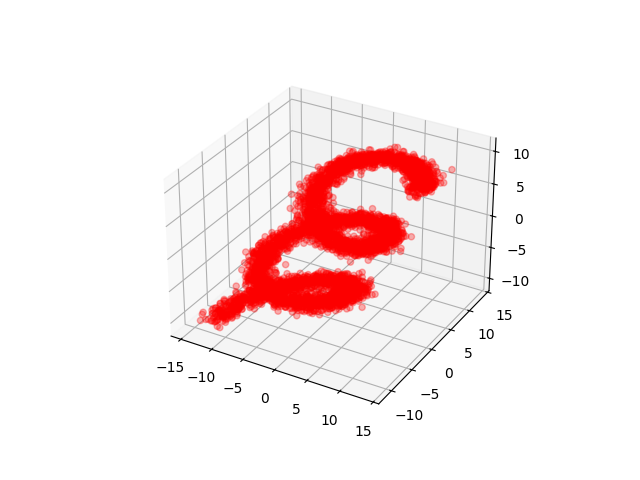

In [2]:
## Generating some data:
NSAMPLE = 5000

z_data = np.float32(np.random.uniform(-10.5, 10.5, NSAMPLE))
r_data = np.random.normal(size=NSAMPLE)
s_data = np.random.normal(size=NSAMPLE)
x_data = np.sin(0.75 * z_data) * 7.0 + z_data * 0.5 + r_data * 1.0
y_data = np.cos(0.80 * z_data) * 6.5 + z_data * 0.5 + s_data * 1.0

x_input = z_data.reshape((NSAMPLE, 1))
y_input = np.array([x_data,y_data])
y_input = y_input.T #reshape to (NSAMPLE,2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.3, c='r') #c=perf_down_sampled.moving
plt.show()

## Build the MDN Model

Now we will construct the MDN model in Keras. This uses the `Sequential` model interface in Keras.

The `MDN` layer comes after one or more `Dense` layers. You need to define the output dimension and number of mixtures for the MDN like so: `MDN(output_dimension, number_mixtures)`.

For this problem, we only need an output dimension of 1 as we are predicting one value (y). Adding more mixtures adds a more parameters (model is more complex, takes longer to train), but might help make the solutions better. You can see from the training data that there are at maximum 5 different layers to predict in the curve, so setting `N_MIXES = 5` is a good place to start.

For MDNs, we have to use a special loss function that can handle the mixture parameters: the function has to take into account the number of output dimensions and mixtures.

In [3]:
N_HIDDEN = 15
N_MIXES = 10
OUTPUT_DIMS = 2

model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(keras.layers.Dense(N_HIDDEN, activation='relu'))
model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=keras.optimizers.Adam())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                30        
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 mdn (MDN)                   (None, 50)                800       
                                                                 
Total params: 1070 (4.18 KB)
Trainable params: 1070 (4.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training the model

Now we train the model using Keras' normal `fit` command.

In [4]:
history = model.fit(x=x_input, y=y_input, batch_size=128, epochs=300, validation_split=0.15, callbacks=[keras.callbacks.TerminateOnNaN()])

Epoch 1/300
34/34 [==============================] - 8s 52ms/step - loss: 15.3987 - val_loss: 12.5345
Epoch 2/300
34/34 [==============================] - 0s 5ms/step - loss: 11.2176 - val_loss: 10.1643
Epoch 3/300
34/34 [==============================] - 0s 6ms/step - loss: 9.3321 - val_loss: 8.6273
Epoch 4/300
34/34 [==============================] - 0s 6ms/step - loss: 8.0708 - val_loss: 7.6025
Epoch 5/300
34/34 [==============================] - 0s 6ms/step - loss: 7.2810 - val_loss: 7.0420
Epoch 6/300
34/34 [==============================] - 0s 6ms/step - loss: 6.8909 - val_loss: 6.7612
Epoch 7/300
34/34 [==============================] - 0s 6ms/step - loss: 6.6683 - val_loss: 6.5835
Epoch 8/300
34/34 [==============================] - 0s 6ms/step - loss: 6.5236 - val_loss: 6.4684
Epoch 9/300
34/34 [==============================] - 0s 5ms/step - loss: 6.4281 - val_loss: 6.3888
Epoch 10/300
34/34 [==============================] - 0s 5ms/step - loss: 6.3566 - val_loss: 6.3252
Epoc

### Training and Validation Loss

It's interesting to see how the model trained. We can see that after a certain point improvement in training is rather slow.

For this problem a loss value around 3.0 produces quite good results.

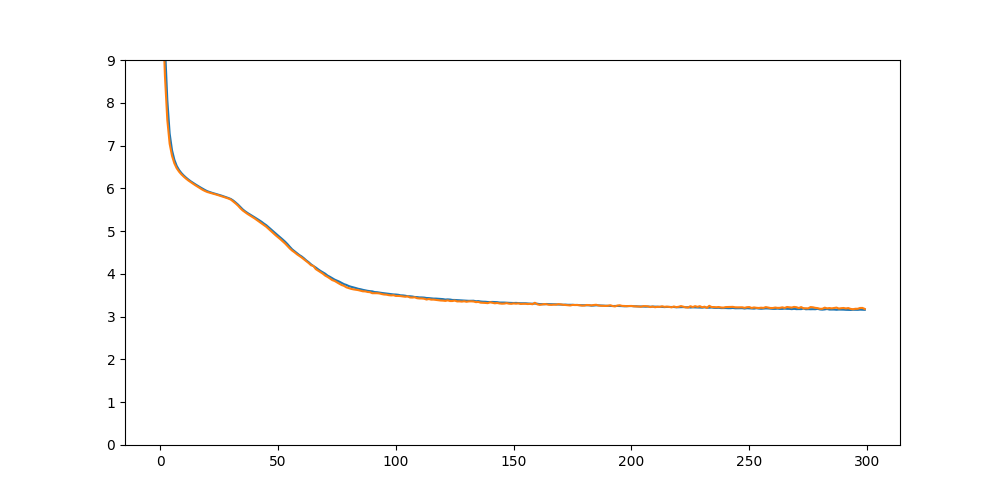

In [5]:
plt.figure(figsize=(10, 5))
plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## Try out the MDN Model

Now we try out the model by making predictions at 3000 evenly spaced points on the x-axis. 

Mixture models output lists of parameters, so we're going to sample from these parameters for each point on the x-axis, and also try plotting the parameters themselves so we can have some insight into what the model is learning!

In [22]:
## Sample on some test data:
x_test = np.float32(np.arange(-15,15,0.05))
NTEST = x_test.size

print("Testing:", NTEST, "samples.")
x_test_pred = x_test.reshape(NTEST,1) # needs to be a matrix for predictions but a vector for display, not a vector

# Make predictions from the model
y_test = model.predict(x_test_pred)
# y_test contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Split up the mixture parameters (for future fun)
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, y_test)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, y_test)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, y_test)

# Sample from the predicted distributions
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, y_test, OUTPUT_DIMS, N_MIXES, temp=1.0, sigma_temp=1.0)

Testing: 600 samples.
19/19 [==============================] - 0s 2ms/step


In [23]:
x_test2 = np.float32(np.arange(-15,15,0.1))
print(x_test2.shape)

print(z_data.shape)
print(x_test.shape)


(300,)
(5000,)
(600,)


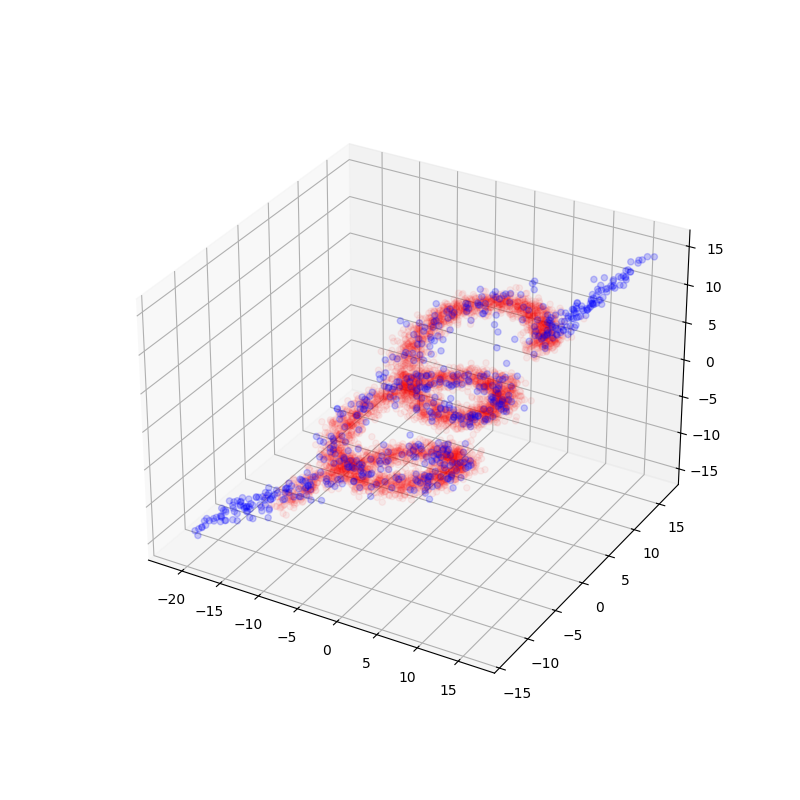

In [24]:
# Plot the predicted samples.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.05, c='r') #c=perf_down_sampled.moving
ax.scatter(y_samples.T[0], y_samples.T[1], x_test, alpha=0.2, c='b') #c=perf_down_sampled.moving
plt.show()

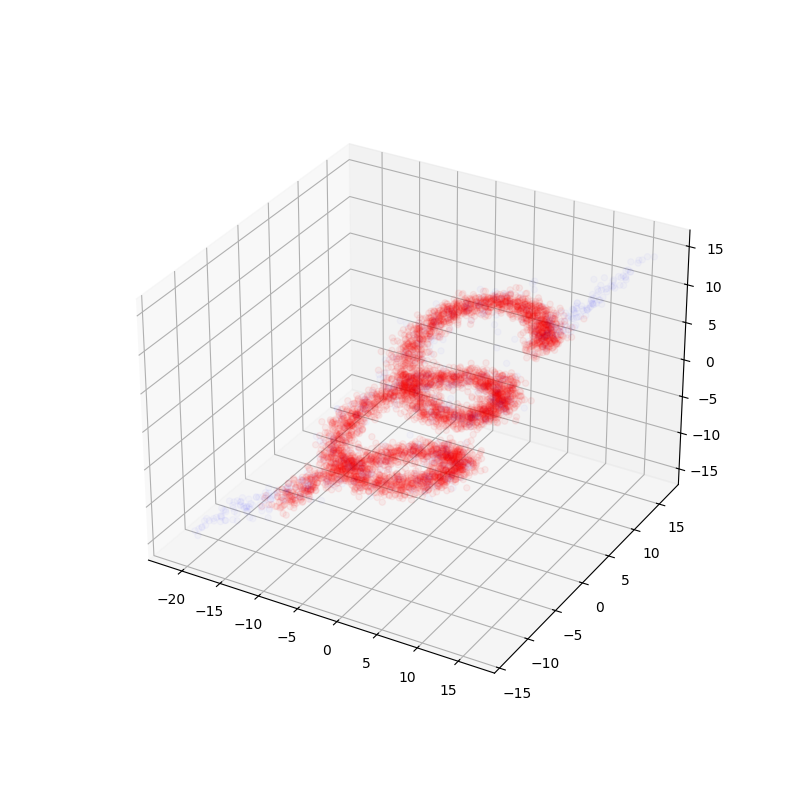

In [25]:
# Plot the predicted samples.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.05, c='r') #c=perf_down_sampled.moving
ax.scatter(y_samples.T[0], y_samples.T[1], x_test, alpha=0.02, c='b') #c=perf_down_sampled.moving
plt.show()

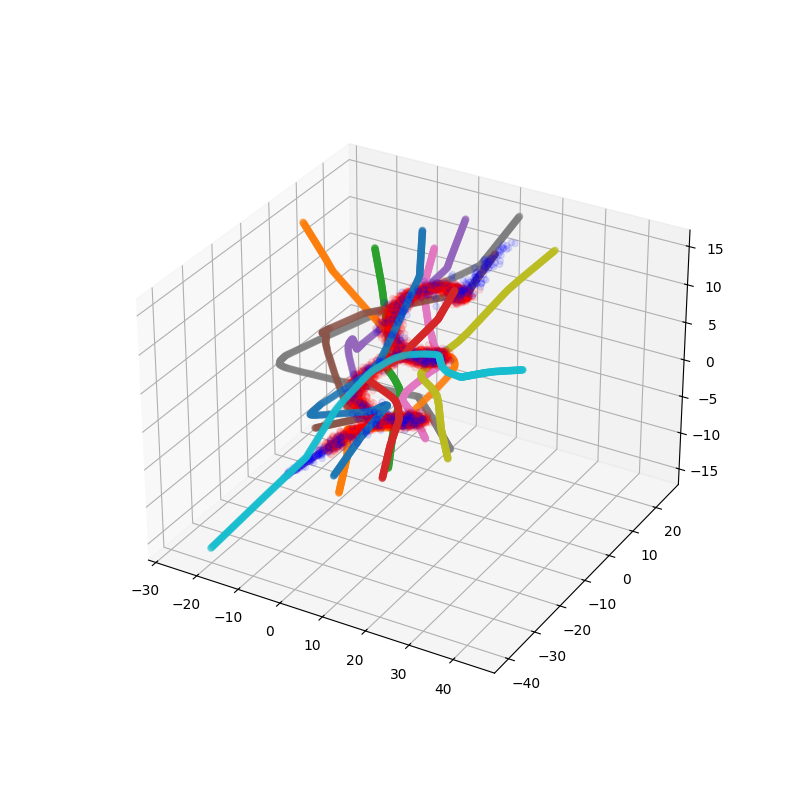

In [26]:
# Plot the means - this gives us some insight into how the model learns to produce the mixtures.
# Cool!

# Plot the predicted samples.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.1, c='r') #c=perf_down_sampled.moving
ax.scatter(y_samples.T[0], y_samples.T[1], x_test, alpha=0.1, c='b') #c=perf_down_sampled.moving
for m in range(N_MIXES):
    one_pair = mus[m*OUTPUT_DIMS:(m+1)*OUTPUT_DIMS]
    ax.scatter(mus[:,2*m], mus[:,2*m + 1] , x_test, marker='o',alpha=0.3)
plt.show()

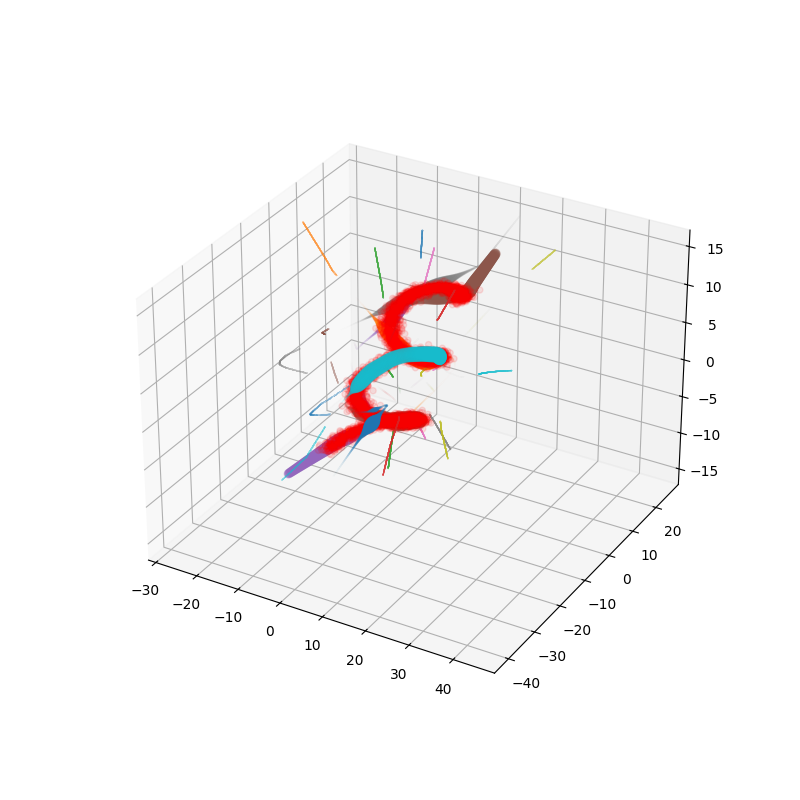

In [27]:
# Let's plot the variances and weightings of the means as well.

# Plot the predicted samples.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.1, c='r') #c=perf_down_sampled.moving
for m in range(N_MIXES):
    one_pair = mus[m*OUTPUT_DIMS:(m+1)*OUTPUT_DIMS]
    ax.scatter(mus[:,2*m], mus[:,2*m + 1] , x_test, s=100*sigs[:,2*m]*pis[:,m], marker='o',alpha=0.3)
plt.show()

## Converting to TensorFlow Lite

We will now convert the keras model into a tflite model. This primarily uses boilerplate code which invokes the TFLiteConverter class and writes the generated model to file. This conversion currently outputs a significant amount of arithmetic conversion errors. From other posts online, this seems to be a superficial issue with converting from 32 bit ints to 64 bit ints and does not affect the validity of the conversion.

In [28]:
# Following code converts high level keras model to a .tflite file 
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()
# Saves converted file to this folder
tflite_model_name = '2-2dspiral-lite.tflite'
with open(tflite_model_name, 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: /tmp/tmpgtqcbxuq/assets


INFO:tensorflow:Assets written to: /tmp/tmpgtqcbxuq/assets
2024-06-13 23:06:28.484404: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-13 23:06:28.484470: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-13 23:06:28.484797: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgtqcbxuq
2024-06-13 23:06:28.486374: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-13 23:06:28.486393: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpgtqcbxuq
2024-06-13 23:06:28.489847: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-13 23:06:28.527277: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpgtqcbxuq
2024-06-13 23:06:28.539378: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

## Predicting using the TensorFlow Lite Model

To make predictions using the tflite runtime, we use the interpreter class. Primarily, this is boilerplate code provided from the tensorflow tutorials. Importantly as our has a model dynamic input shape (as indicated by us defining the keras model with a first layer with batch_input_shape=(None, 1)) we must define the input tensor manually using resize_tensor_input. Now, we will test the tflite model on our original training data and compare it to the keras model.

In [29]:
# Load the TFLite model and allocate tensors.
# Note that it assumes we are loading the model just saved to the current folder
# to interpret from a model we have just generated, use model_content=tflite_model as the parameter instead
interpreter = tf.lite.Interpreter(model_path=tflite_model_name) 

# Resize input shape for dynamic shape model and allocate tensor
interpreter.resize_tensor_input(interpreter.get_input_details()[0]['index'], (NTEST,1))
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on our defined testing set
# Important: remember we use the x_test_pred as it has correct dimension for predictions, x_test has dimension for graphing
interpreter.set_tensor(input_details[0]['index'], x_test_pred)

# Uses the interpreter to make the same predictions as our keras model
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
y_test_tflite = interpreter.get_tensor(output_details[0]['index'])


# Sample from the TFLite predicted distributions as done previously
y_samples_tflite = np.apply_along_axis(mdn.sample_from_output, 1, y_test_tflite, OUTPUT_DIMS, N_MIXES, temp=1.0, sigma_temp=1.0)

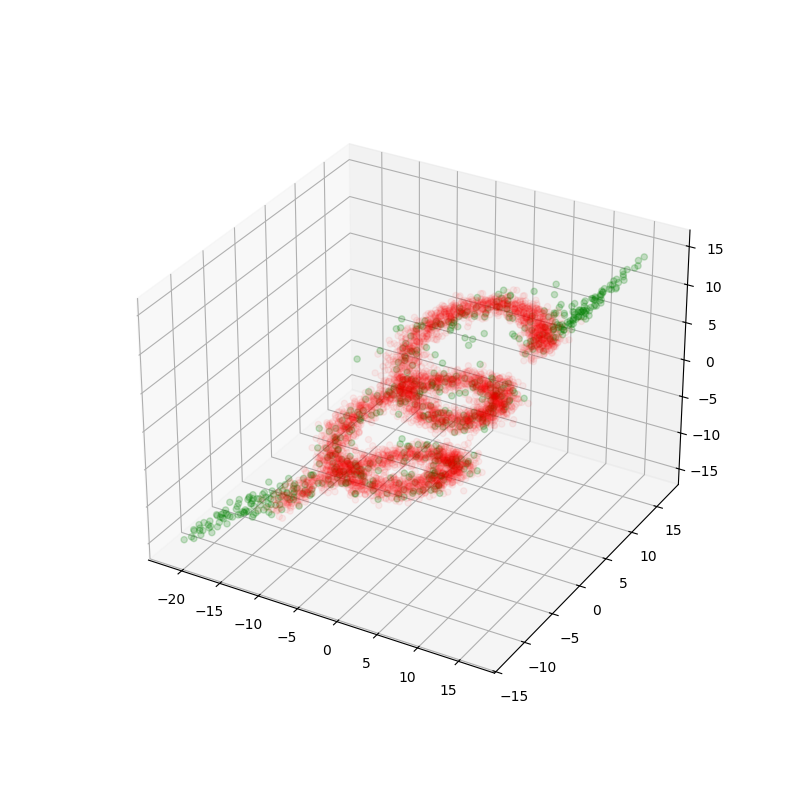

In [30]:
# Plot the predicted samples.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.05, c='r') #c=perf_down_sampled.moving
ax.scatter(y_samples_tflite.T[0], y_samples_tflite.T[1], x_test, alpha=0.2, c='g') #c=perf_down_sampled.moving
plt.show()
# The model clearly successfully predicts our dataset.

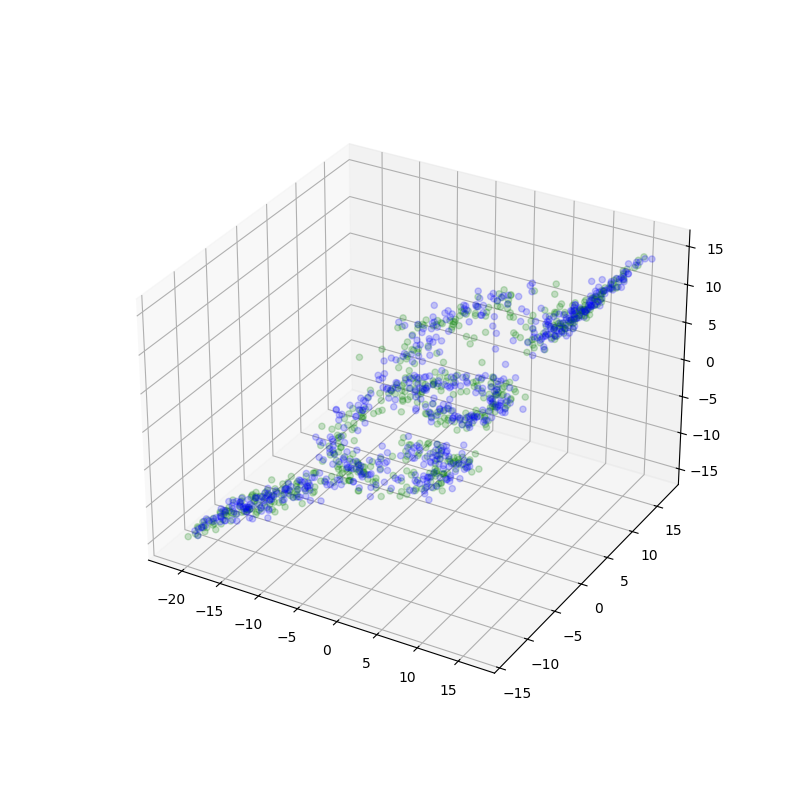

In [31]:
# Plot the Keras and TFLite model predictions
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_samples.T[0], y_samples.T[1], x_test, alpha=0.2, c='b') #c=perf_down_sampled.moving
ax.scatter(y_samples_tflite.T[0], y_samples_tflite.T[1], x_test, alpha=0.2, c='g') #c=perf_down_sampled.moving
plt.show()
# The models clearly behave quite similarly